In [1]:
import projX
%matplotlib notebook

In [2]:
trajfile = 'data/c-alpha_centered.stride.100.xtc'
top = 'data/bpti-c-alpha_centered.pdb'

In [3]:
# Skip TICA if you already have an Y.npy file
try:
    
    import numpy as np
    Y = np.load('data/Y.npy')
except:
    import pyemma
    feat = pyemma.coordinates.featurizer(top)
    pairs = feat.pairs(range(feat.topology.n_atoms)[::2])
    feat.add_distances(pairs)
    src  = pyemma.coordinates.source(trajfile, features=feat)
    tica = pyemma.coordinates.tica(src, lag=100, dim=2)
    Y = tica.get_output()[0]
    np.save('data/Y.npy', Y)

# Do "structure-sampling" of a given FES
Execute the following cell and click either on the FES or on the slidebar

<IPython.core.display.Javascript object>


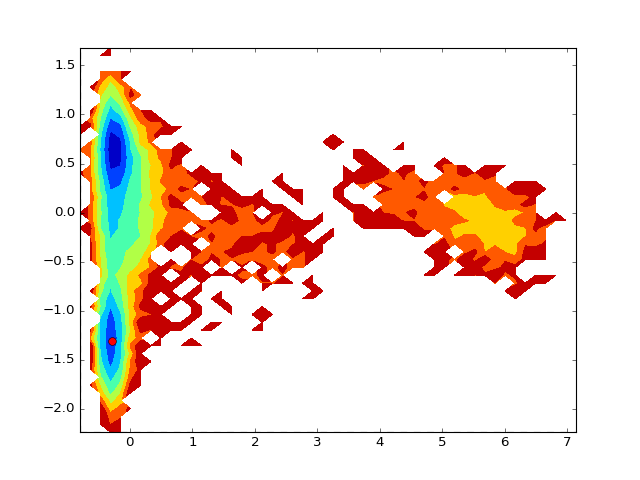

/home/mi/gph82/SOURCE_gph82/python/projection_explorer/projX/api.py:179: RuntimeWarning: divide by zero encountered in log
  _plt.contourf(-_np.log(h).T, extent=irange)


In [14]:
ax, fig, iwd, sample, geom = projX.visualize_FES(trajfile, top, 'data/Y.npy', 
                                          )
iwd

# Do "trajectory-sampling" of a given FES
This can be more time consuming and prettly slow, but is a proof of function. The user can sample structures as they occurr in sequence in the actual trajectory

<IPython.core.display.Javascript object>


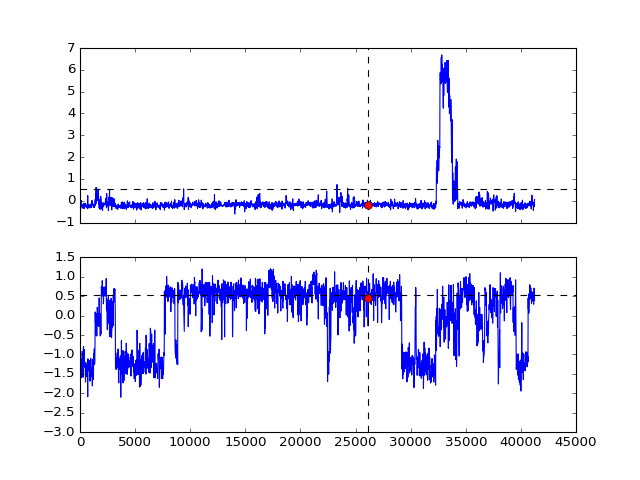

<IPython.core.display.Javascript object>


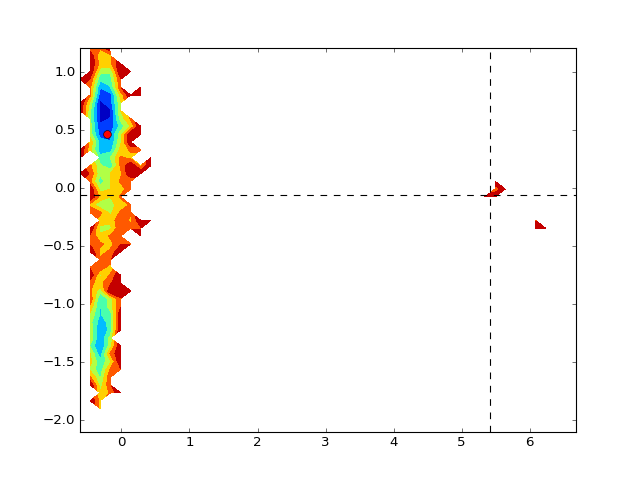

/home/mi/gph82/SOURCE_gph82/python/projection_explorer/projX/api.py:232: RuntimeWarning: divide by zero encountered in log
  _plt.contourf(-_np.log(h).T, extent=irange)


In [15]:
__, __, iwd, __ = projX.visualize_traj(trajfile, top, 
                                       'data/Y.npy', 
                                       plot_FES = True,
                                       max_frames=2000
                          )
iwd

# Intermediate steps: use projX to generate a regspace sample of the data

In [6]:
sample, geoms = projX.generate_sample(trajfile, top, Y, 
                                      n_points=200
                                      #keep_all_samples=True,                                      
                                      #n_geom_samples=200,
                                      #verbose=True
                                    )
sample.shape, geoms

09-01-17 18:29:34 pyemma.coordinates.clustering.regspace.RegularSpaceClustering[1] WARNING  Maximum number of cluster centers reached. Consider increasing max_centers or choose a larger minimum distance, dmin.
09-01-17 18:29:34 pyemma.coordinates.clustering.regspace.RegularSpaceClustering[1] INFO     Presumably finished estimation. Message: Used data for centers: 84.85%


/home/mi/gph82/programs/PyEmma/pyemma/coordinates/clustering/regspace.py:151: UserWarning: Maximum number of cluster centers reached. Consider increasing max_centers or choose a larger minimum distance, dmin.
  warnings.warn(msg)


((191, 2),
 <mdtraj.Trajectory with 191 frames, 58 atoms, 58 residues, and unitcells at 0x7fd5201a14a8>)

# Link the PDF plot with the sampled structures and visually explore the FES 
Click either on the plot or on the widget slidebar: they're connected! 

In [7]:
# Replot the FES
from matplotlib import pylab as plt
plt.figure(figsize=(10,10))
h, (x,y) = np.histogramdd(Y, bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)
# Create the linked widget
linked_wdg = projX.visualize_sample(sample, 
                              geoms.superpose(geoms[0]),                             
                              plt.gca(), 
                              clear_lines=True,
                              #plot_path=True
                            )
plt.plot(sample[:,0], sample[:,1],' ok', zorder=0)
# Show it
linked_wdg

<IPython.core.display.Javascript object>

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


# Instead of sampling the full space, use projX to generate paths along the different projections/axis

In [8]:
paths_dict, idata = projX.generate_paths(trajfile, top, 
                                         'data/Y.npy', 
                                         #Y, # You can also directly give the data here
                                         n_projs=2,
                                         verbose=False, 
                                        )

# Link the PDF plot with the sampled paths/structures and visually explore the coordinates (separately). 
Click either on the plot or on the widget slidebar: they're connected! You can change the type of path between min_rmsd or min_disp and you can also change the coordinate sampled (0 or 1)


In [9]:
# Choose the coordinate and the tyep of path
coord = 0
path_type = 'min_rmsd'
#path_type = 'min_disp'
igeom = paths_dict[coord][path_type]["geom"]
ipath = paths_dict[coord][path_type]["proj"]

In [10]:
plt.figure(figsize=(10,10))
h, (x,y) = np.histogramdd(Y, bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

linked_wdg = projX.visualize_sample(ipath, 
                              igeom.superpose(igeom[0]),                             
                              plt.gca(), 
                              clear_lines=True,
                              plot_path=True
                            )
linked_wdg

<IPython.core.display.Javascript object>

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


# You can even provide your own clustering object...

In [12]:
from pyemma.coordinates import cluster_kmeans
clkmeans = cluster_kmeans(Y, 10)
sample, geoms = projX.generate_sample(trajfile, top, clkmeans, 
                                     n_geom_samples=50, 
                                     keep_all_samples=True # read the doc for this argument
                                    )

09-01-17 18:30:23 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


<IPython.core.display.Javascript object>


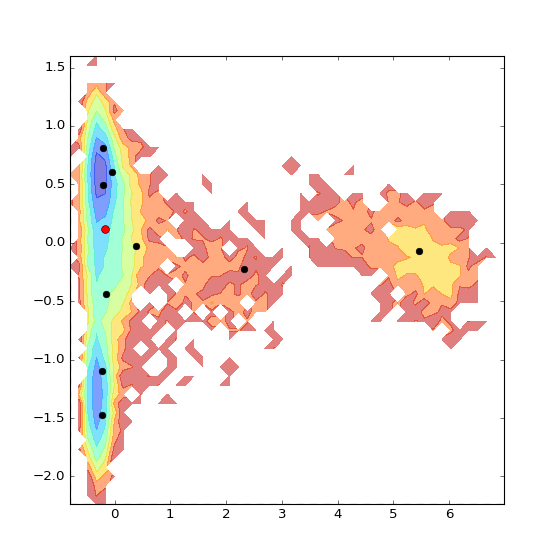

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [13]:
plt.figure(figsize=(7,7))
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)
plt.plot(clkmeans.clustercenters[:,0], clkmeans.clustercenters[:,1],' ok')
iwdg = projX.visualize_sample(sample, 
                              geoms.superpose(geoms[0]),                             
                              plt.gca(), 
                              clear_lines=False,
                              #plot_path=True
                            )
iwdg

In [ ]:
# Check
# https://github.com/arose/nglview/issues/518
# https://github.com/arose/nglview/issues/517

# Intefacing with VMD 
This is a WIP

In [ ]:
#plt.figure()
#plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

In [ ]:
#import bmutils
#from imp import reload
#reload(bmutils)
#vmdpipe = bmutils.link_ax_w_pos_2_vmd(plt.gca(), sample, geoms, rep='Trace', 
                           # freetext= 'start_sscache\n'
#                           )